In [1]:
model_path = 'models/refcoco.pth'
bert_config_path = 'configs/config_bert.json'
use_cuda = False

In [2]:
import sys
from functools import partial
from models.vit import VisionTransformer
from models.xbert import BertConfig, BertModel
# from models.tokenization_bert import BertTokenizer

import torch
from torch import nn
from torchvision import transforms

import json

class VL_Transformer_ITM(nn.Module):
    def __init__(self,                 
                 text_encoder = None,
                 config_bert = ''
                 ):
        super().__init__()
    
        bert_config = BertConfig.from_json_file(config_bert)

        self.visual_encoder = VisionTransformer(
            img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6)) 

        self.text_encoder = BertModel.from_pretrained(text_encoder, config=bert_config, add_pooling_layer=False)   
        
        self.itm_head = nn.Linear(768, 2) 

        
    def forward(self, image, text):
        image_embeds = self.visual_encoder(image) 

        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        output = self.text_encoder(text.input_ids, 
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,      
                                return_dict = True,
                               )     
           
        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)   
        return vl_output

/home/wg25r/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import re

def pre_caption(caption,max_words=30):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])            
    return caption

In [4]:
from PIL import Image

import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt
import torchvision.transforms

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = torchvision.transforms.functional.resize(attMap.unsqueeze(0), (img.shape[:2]), interpolation=Image.BICUBIC)[0].detach().cpu().numpy()
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])     

In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = VL_Transformer_ITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)

checkpoint = torch.load(model_path, map_location='cpu')              
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()

block_num = 8

model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

if use_cuda:
    model.cuda() 

/tmp/ipykernel_3108591/1211269893.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


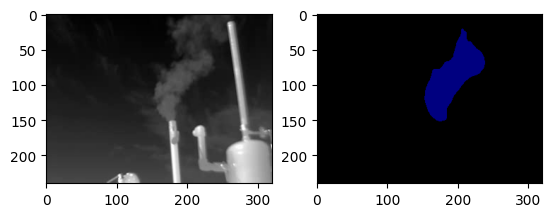

In [6]:
import os
import cv2
import pylab
root_path = "/mnt/fastdata/marshall/gasvid_val"
idx = 1000
files = os.listdir(os.path.join(root_path, "images"))
pylab.subplot(1,2,1)
pylab.imshow(cv2.imread(os.path.join(root_path, "images", files[idx])))
pylab.subplot(1,2,2)
pylab.imshow(cv2.imread(os.path.join(root_path, "masks", files[idx].replace("jpg", "png"))))
# pylab.imshow(cv2.imread(os.path.join(root_path, "softmask", files[idx])))

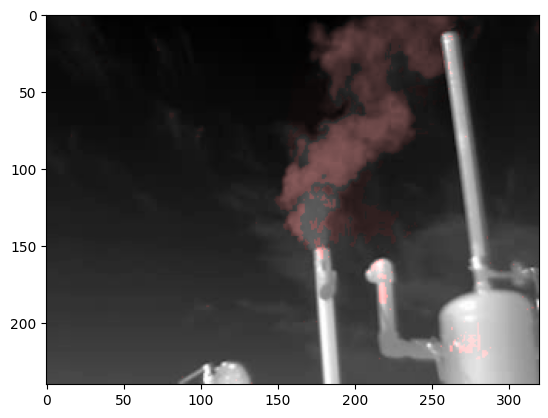

In [7]:
from PIL import Image
text_input = "red and white steam coming from a pipe"
text_input = pre_caption(text_input)
text_input = tokenizer(text_input, return_tensors="pt")
image = Image.open(os.path.join(root_path, "images", files[idx]))
softmask = Image.open(os.path.join(root_path, "softmask", files[idx]))
# make image where softmask area is more red
image = np.array(image)
softmask = np.array(softmask)
red_image = image.copy().astype(int)
red_image[:,:,0] = 1.5 * red_image[:,:,0]
red_image = np.clip(red_image, 0, 255)
red_image = np.where(softmask > 5, red_image, image)
red_image = Image.fromarray(red_image.astype(np.uint8))
pylab.imshow(red_image)

In [8]:
from PIL import Image
text_input = "red steam (not cloud) coming from a pipe with background of sky and chemical plant"
text_input = pre_caption(text_input)
text_input = tokenizer(text_input, return_tensors="pt")
image = Image.open(os.path.join(root_path, "images", files[idx]))
softmask = Image.open(os.path.join(root_path, "softmask", files[idx]))
# make image where softmask area is more red
image = np.array(image)
softmask = np.array(softmask)
red_image = image.copy().astype(int)
red_image[:,:,0] = 1.5 * red_image[:,:,0]
red_image = np.clip(red_image, 0, 255)
red_image = np.where(softmask > 10, red_image, image)
red_image = Image.fromarray(red_image.astype(np.uint8))

image = transform(red_image).unsqueeze(0)
output = model(image, text_input)
loss = output[:,1].sum()

model.zero_grad()
loss.backward()    

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

    grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
    cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

/tmp/ipykernel_3108591/70591797.py:17: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000298023224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0

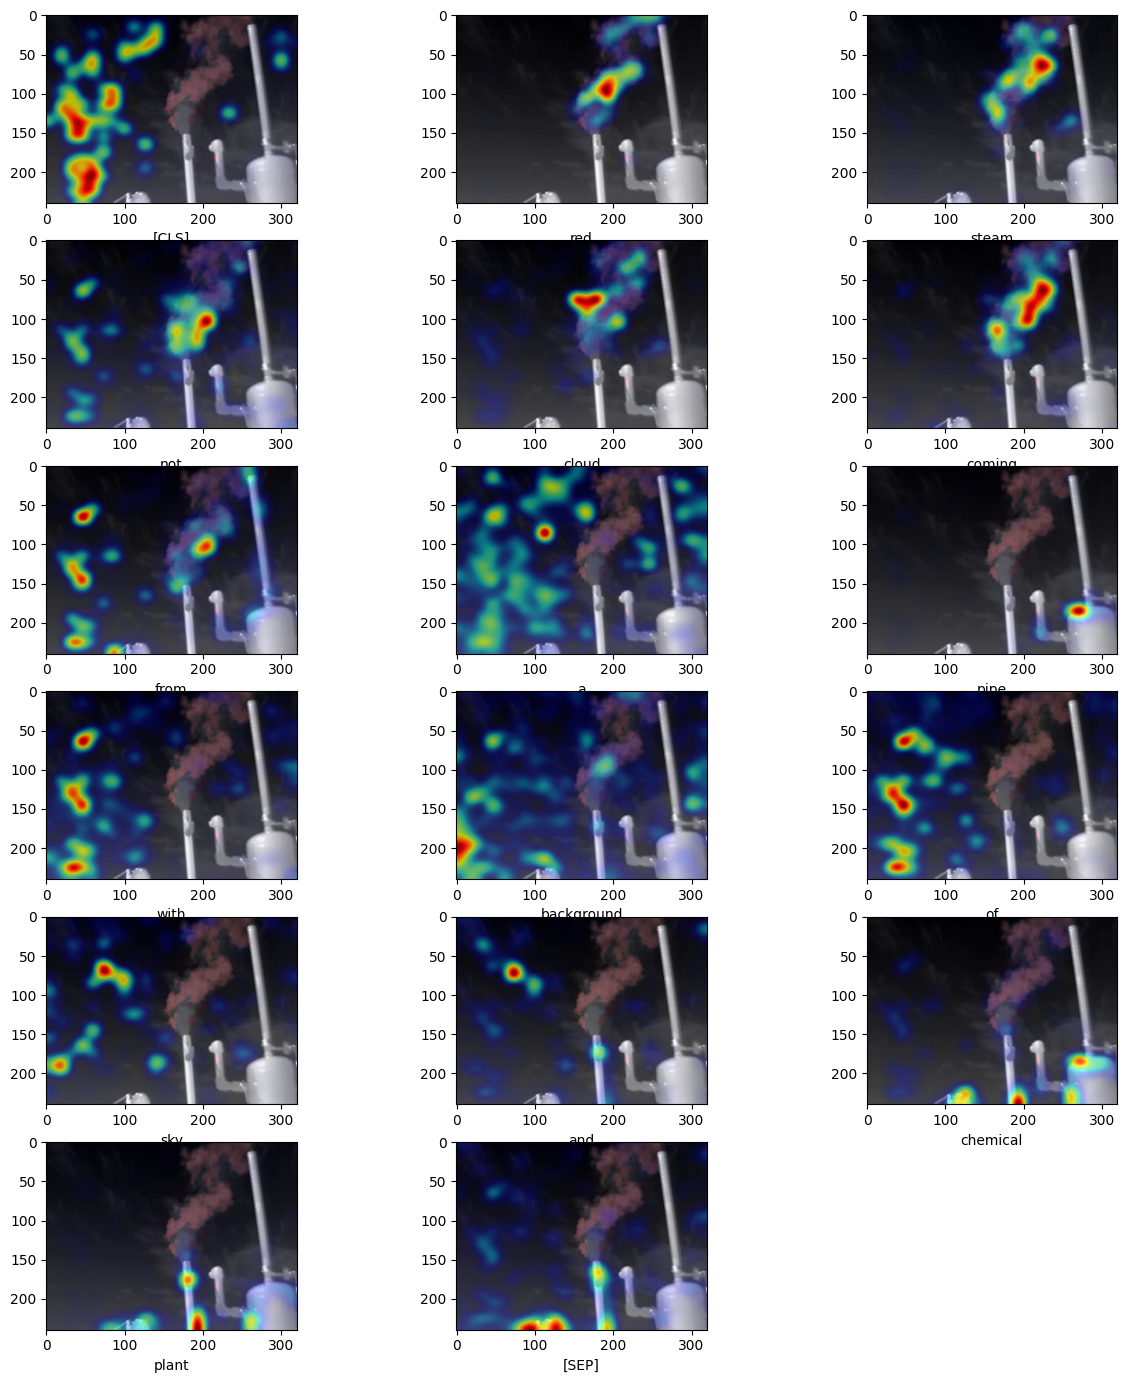

In [9]:
pylab.figure(figsize=(15, 20))
num_image = len(text_input.input_ids[0]) + 1 
# fig, ax = plt.subplots(num_image//3 + 1, 3, figsize=(15,5*num_image))

pylab.subplot(num_image//3 + 1 , 3, 1)
pylab.imshow(red_image)
pylab.xlabel("Image")

for i,token_id in enumerate(text_input.input_ids[0]):
    word = tokenizer.decode([token_id])
    gradcam_image = getAttMap(np.array(red_image)/255, gradcam[i])
    pylab.subplot(num_image//3 + 1 , 3, 1 + i)
    pylab.imshow(gradcam_image)
    pylab.xlabel(word)

In [10]:
words = [tokenizer.decode([token_id]) for token_id in text_input.input_ids[0]]
words

['[CLS]',
 'red',
 'steam',
 'not',
 'cloud',
 'coming',
 'from',
 'a',
 'pipe',
 'with',
 'background',
 'of',
 'sky',
 'and',
 'chemical',
 'plant',
 '[SEP]']

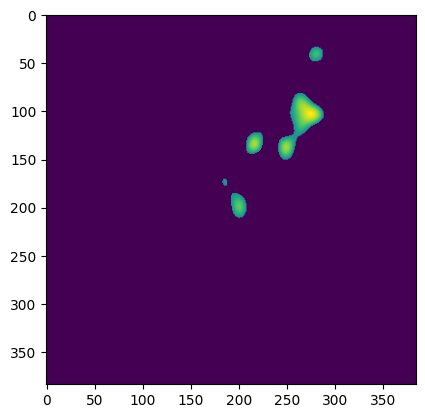

In [ ]:
map_of_interest = gradcam[words.index("steam")].detach().cpu().numpy()
map_of_interest = cv2.resize(map_of_interest, (384, 384), interpolation = cv2.INTER_CUBIC)  
map_of_interest = cv2.blur(map_of_interest, (10,10))
segmented = map_of_interest > 0.5
map_of_interest = np.where(segmented, map_of_interest, 0)
pylab.imshow(map_of_interest)

In [ ]:
map_of_interest = gradcam[words.index("steam")].detach().cpu().numpy()
map_of_interest = cv2.resize(map_of_interest, (384, 384), interpolation = cv2.INTER_CUBIC)  
map_of_interest = cv2.blur(map_of_interest, (10,10))
segmented = map_of_interest > 0.5
map_of_interest = np.where(segmented, map_of_interest, 0)
pylab.imshow(map_of_interest)

/tmp/ipykernel_3108591/702065880.py:8: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))
/tmp/ipykernel_3108591/702065880.py:22: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))


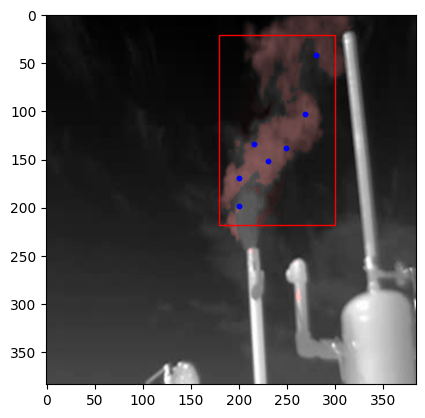

In [11]:
map_of_interest = gradcam[words.index("steam")].detach().cpu().numpy()
map_of_interest = cv2.resize(map_of_interest, (384, 384), interpolation = cv2.INTER_CUBIC)  
map_of_interest = cv2.blur(map_of_interest, (10,10))
segmented = map_of_interest > 0.6
from scipy import ndimage
from skimage import measure
labels, n = ndimage.label(segmented)
com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))

# pylab.imshow(map_of_interest, cmap='gray')
pylab.imshow(red_image.resize((384,384)))
pylab.scatter([c[1] for c in com], [c[0] for c in com], c='b', s=10)
positive_points =  [[(c[1], c[0]) for c in com]] 

map_of_interest = gradcam[words.index("red")].detach().cpu().numpy()
map_of_interest = cv2.resize(map_of_interest, (384, 384), interpolation = cv2.INTER_CUBIC)  
map_of_interest = cv2.blur(map_of_interest, (10,10))
segmented = map_of_interest > 0.6
from scipy import ndimage
from skimage import measure
labels, n = ndimage.label(segmented)
com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))

# pylab.imshow(map_of_interest, cmap='gray')
pylab.imshow(red_image.resize((384,384)))
pylab.scatter([c[1] for c in com], [c[0] for c in com], c='b', s=10)
positive_points[0].extend([(c[1], c[0]) for c in com])

x_coords = [point[0] for point in positive_points[0]]
y_coords = [point[1] for point in positive_points[0]]

min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

expanded_min_x = min_x - 20
expanded_max_x = max_x + 20
expanded_min_y = min_y - 20
expanded_max_y = max_y + 20

bounding_box = (expanded_min_x, expanded_min_y, expanded_max_x, expanded_max_y)
# draw the bounding box on pylab
rect = plt.Rectangle((expanded_min_x, expanded_min_y), expanded_max_x - expanded_min_x, expanded_max_y - expanded_min_y, linewidth=1, edgecolor='r', facecolor='none')
pylab.gca().add_patch(rect)


In [31]:
torch.tensor(bounding_box).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 4])

In [26]:
positive_points

[[(279.7283950617284, 40.901234567901234),
  (268.8687415426252, 102.37889039242219),
  (215.7887323943662, 133.63849765258215),
  (249.24454148471617, 137.75982532751092),
  (199.49714285714285, 198.53142857142856),
  (230.19167717528373, 151.48171500630517),
  (199.5340909090909, 168.76136363636363)]]

[[(279.7283950617284, 40.901234567901234),
  (268.8687415426252, 102.37889039242219),
  (215.7887323943662, 133.63849765258215),
  (249.24454148471617, 137.75982532751092),
  (199.49714285714285, 198.53142857142856),
  (230.19167717528373, 151.48171500630517),
  (199.5340909090909, 168.76136363636363)]]

/tmp/ipykernel_2606232/3900880792.py:11: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))
/tmp/ipykernel_2606232/3900880792.py:28: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))


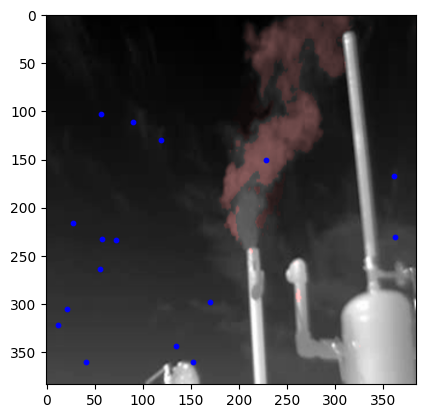

In [32]:
map_of_interest = gradcam[words.index("sky")].detach().cpu().numpy()
map_of_interest = cv2.resize(map_of_interest, (384, 384), interpolation = cv2.INTER_CUBIC)  
map_of_interest = cv2.blur(map_of_interest, (10,10))
segmented = map_of_interest > 0.5
# find the center of mass for each segment
from scipy import ndimage
from skimage import measure
# label each segment
labels, n = ndimage.label(segmented)
# get the center of mass
com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))

# pylab.imshow(map_of_interest, cmap='gray')
pylab.imshow(red_image.resize((384,384)))
pylab.scatter([c[1] for c in com], [c[0] for c in com], c='b', s=10)
negative_points =  [[(c[1], c[0]) for c in com]]

map_of_interest = gradcam[words.index("background")].detach().cpu().numpy()
map_of_interest = cv2.resize(map_of_interest, (384, 384), interpolation = cv2.INTER_CUBIC)  
map_of_interest = cv2.blur(map_of_interest, (10,10))
segmented = map_of_interest > 0.5
# find the center of mass for each segment
from scipy import ndimage
from skimage import measure
# label each segment
labels, n = ndimage.label(segmented)
# get the center of mass
com = ndimage.measurements.center_of_mass(segmented, labels, range(1, n+1))

# pylab.imshow(map_of_interest, cmap='gray')
pylab.imshow(red_image.resize((384,384)))
pylab.scatter([c[1] for c in com], [c[0] for c in com], c='b', s=10)
negative_points[0].extend([(c[1], c[0]) for c in com])

In [33]:
torch.tensor(positive_points).shape, torch.tensor(negative_points).shape

(torch.Size([1, 7, 2]), torch.Size([1, 16, 2]))

In [34]:
all_points = torch.cat([torch.tensor(positive_points), torch.tensor(negative_points)], dim=1)
labels = torch.tensor([1] * len(positive_points[0]) + [-1] * len(negative_points[0])).unsqueeze(0).unsqueeze(0)

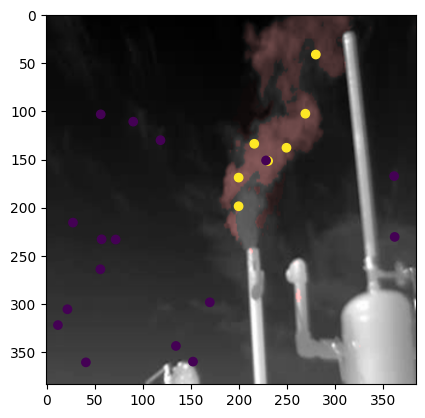

In [35]:
pylab.imshow(red_image.resize((384,384)))
pylab.scatter(all_points.numpy()[0][:,0], all_points.numpy()[0][:,1], c=labels)

In [36]:
# prompt to SAM
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("facebook/sam-vit-base").cuda()
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [43]:
raw_image = (red_image).resize((384,384)).convert("RGB")

input_points = all_points

inputs = processor(raw_image, input_points=input_points, input_labels=labels, input_boxes=torch.tensor(bounding_box).unsqueeze(0).unsqueeze(0), return_tensors="pt").to("cuda")
outputs = model(**inputs)

/home/wg25r/.local/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [44]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores
best_idx = scores.argmax()

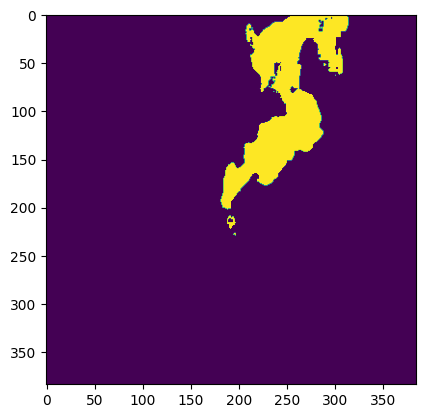

In [45]:
pylab.imshow(masks[0][0][best_idx]) 

In [40]:
class BinaryConfusionMatrix:
    def __init__(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.tn = 0

    def update(self, y_pred: np.ndarray, y_true: np.ndarray):
        assert y_pred.shape == y_true.shape, "y_pred and y_true must have the same shape " + str(y_pred.shape) + " != " + str(y_true.shape)
        self.tp += np.sum((y_pred == 1) & (y_true == 1))
        self.fp += np.sum((y_pred == 1) & (y_true == 0))
        self.fn += np.sum((y_pred == 0) & (y_true == 1))
        self.tn += np.sum((y_pred == 0) & (y_true == 0))

    def get_iou(self):
        denominator = self.tp + self.fp + self.fn
        if denominator == 0:
            return -0.01
        return self.tp / denominator

    def get_f1(self):
        precision = self.get_precision()
        recall = self.get_recall()
        if precision + recall == 0:
            return -0.01
        return 2 * (precision * recall) / (precision + recall)

    def get_precision(self):
        denominator = self.tp + self.fp
        return self.tp / denominator if denominator > 0 else 0

    def get_recall(self):
        denominator = self.tp + self.fn
        return self.tp / denominator if denominator > 0 else 0

In [41]:
pred = masks[0][0][best_idx].numpy()
gt = cv2.resize(cv2.imread(os.path.join(root_path, "masks", files[idx].replace("jpg", "png")), cv2.IMREAD_GRAYSCALE), (384, 384), interpolation = cv2.INTER_CUBIC) > 0
confusion_matrix = BinaryConfusionMatrix()
confusion_matrix.update(pred, gt)
confusion_matrix.get_iou(), confusion_matrix.get_f1(), confusion_matrix.get_precision(), confusion_matrix.get_recall()

(0.4157880323154868, 0.5873591566323323, 0.554409348183312, 0.6244730077120823)

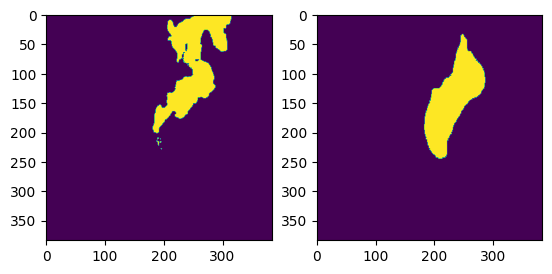

In [42]:
pylab.subplot(1,2,1)
pylab.imshow(masks[0][0][best_idx])
pylab.subplot(1,2,2)
pylab.imshow(gt)